In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn

In [3]:
num_points = 75
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

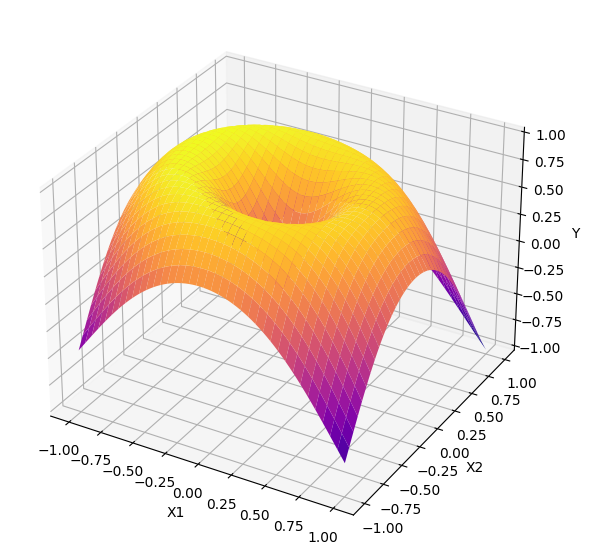

In [4]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)
xx, yy = torch.FloatTensor(xx), torch.FloatTensor(yy)


%matplotlib inline
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [5]:
## Define piecewise MLP
torch.manual_seed(103)

h = 8
net = nn.Sequential(
            nn.Linear(2, h),
            nn.ReLU(),
            nn.Linear(h, 1),
)

In [6]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [7]:
xx, yy = xx.to(device), yy.to(device)
net.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)

In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [9]:
# fig = plt.figure(figsize=(9,8))
# ax = plt.axes(projection='3d')

for epoch in range(5000):

    yout = net(xx)
    loss =criterion(yout, yy)
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')
#         ax.clear()
        
#         ax.scatter(X1, X2, Y)
#         yout_ = yout.reshape(Y.shape)
#         ax.scatter(X1, X2, yout_, color='r', marker='.')
#         ax.set_xlabel('X1')
#         ax.set_ylabel('X2')
#         ax.set_zlabel('Y')
        
#         fig.canvas.draw()
#         plt.pause(0.01)

Epoch:0 | Error:1.0740708112716675
Epoch:200 | Error:0.25157350301742554
Epoch:400 | Error:0.13053615391254425
Epoch:600 | Error:0.1143478974699974
Epoch:800 | Error:0.10312841832637787
Epoch:1000 | Error:0.09313517808914185
Epoch:1200 | Error:0.08480628579854965
Epoch:1400 | Error:0.07833268493413925
Epoch:1600 | Error:0.07308680564165115
Epoch:1800 | Error:0.06815246492624283
Epoch:2000 | Error:0.06304516643285751
Epoch:2200 | Error:0.0575232096016407
Epoch:2400 | Error:0.051700472831726074
Epoch:2600 | Error:0.046160127967596054
Epoch:2800 | Error:0.04116588458418846
Epoch:3000 | Error:0.03676963597536087
Epoch:3200 | Error:0.03302222117781639
Epoch:3400 | Error:0.029922479763627052
Epoch:3600 | Error:0.027482492849230766
Epoch:3800 | Error:0.025544457137584686
Epoch:4000 | Error:0.023774966597557068
Epoch:4200 | Error:0.02232581004500389
Epoch:4400 | Error:0.02124941162765026
Epoch:4600 | Error:0.020375704392790794
Epoch:4800 | Error:0.01961134932935238


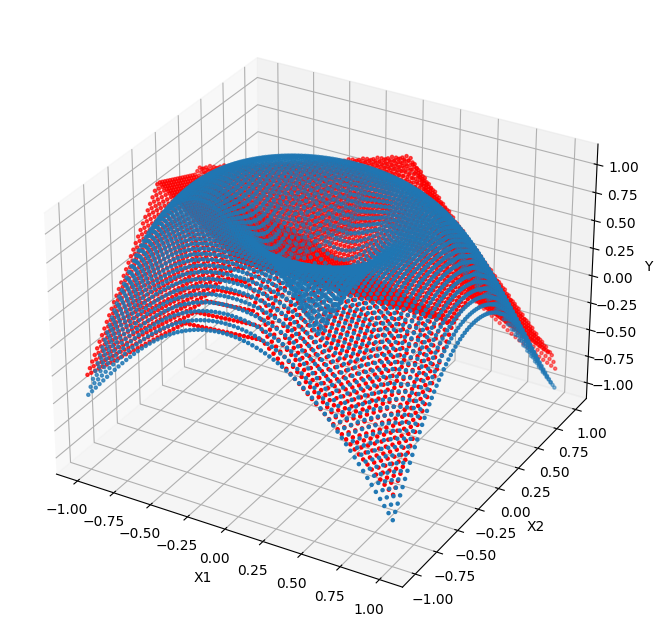

In [10]:
%matplotlib inline

yout_ = yout.data.cpu().reshape(Y.shape)

fig = plt.figure(figsize=(9,8))
ax = plt.axes(projection='3d')
ax.scatter(X1, X2, Y, marker= '.')
ax.scatter(X1, X2, yout_, color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [11]:
### Extracting the pieces
###### equation of line where (wx+b) == 0

## (x1w1 + x2w2 + b = 0) ... solving
## x2 = (-b-w1x1)/w2

## lets draw line given x1 is in -2 and 2.
lines = []
vecs = []
mcs = []
for i in range(len(net[0].bias)):
    ## for x1 = -2 and 2
    with torch.no_grad():
        w1, w2 = net[0].weight.t()[:, i]
        b = net[0].bias[i]
        x2_a = -(b+w1*-2)/w2
        x2_b = -(b+w1*2)/w2
        lines.append([(-2, x2_a), (2, x2_b)])
#         lines.append([(-1, x2_a), (1, x2_b)])
        
        vecs.append([w1, w2])
        ## x1w1 + x2w2 + b = 0
        ## x2 = (-x1w1-b)/w2
        mcs.append([-w1/w2, -b/w2])

In [12]:
lines = torch.Tensor(lines).cpu().numpy()
vecs = torch.Tensor(vecs).cpu().numpy()
mcs = torch.Tensor(mcs).cpu().numpy()
lines

array([[[-2.        ,  1.7577071 ],
        [ 2.        ,  0.6383481 ]],

       [[-2.        ,  1.8485053 ],
        [ 2.        ,  0.59837884]],

       [[-2.        ,  0.4477436 ],
        [ 2.        , -0.59115285]],

       [[-2.        ,  2.7489142 ],
        [ 2.        , -1.098555  ]],

       [[-2.        ,  0.46483433],
        [ 2.        , -2.2347753 ]],

       [[-2.        ,  4.658342  ],
        [ 2.        , -0.39959088]],

       [[-2.        , -0.0902527 ],
        [ 2.        ,  1.2769344 ]],

       [[-2.        , -1.8328245 ],
        [ 2.        ,  0.1646645 ]]], dtype=float32)

In [13]:
## make lines with max norm of 1
lines = lines.reshape(-1, 2)
# lines = lines/np.linalg.norm(lines, axis=1, keepdims=True)
lines = lines.reshape(-1, 2,2)

In [14]:
vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

In [15]:
## interpolation of points along the lines
# interp = np.linspace(0, 1, 20)
# interp.shape, lines.shape

In [16]:
# interp = interp.reshape(-1,1)

In [17]:
lines[0]

array([[-2.       ,  1.7577071],
       [ 2.       ,  0.6383481]], dtype=float32)

In [18]:
vecs[0]

array([-0.2694868 , -0.96300405], dtype=float32)

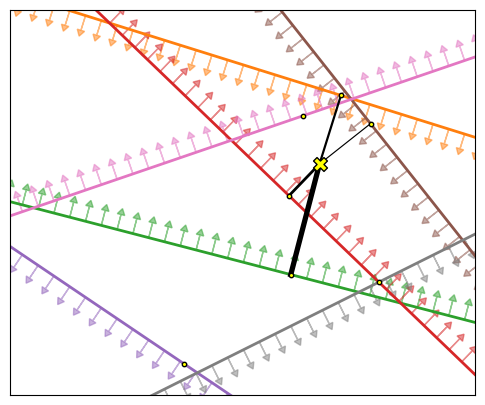

In [19]:
## plot the lines
_x0, _x1 = 0.75, 0.5
actv = net[:2](torch.Tensor([[_x0, _x1]])).data.reshape(-1)

plt.figure(figsize=(6,5))
for i, line in enumerate(lines):
    if i == 0: continue
    color = matplotlib.cm.tab10(i)
    plt.plot(line[:,0], line[:,1], c=color, lw=2)
#     plt.arrow(0, 0, vecs[i][0]/4, vecs[i][1]/4, head_width=0.05, head_length=0.04, fc=color, ec=color, linestyle='solid', alpha=0.5)
    
    distance = ((lines[i, 0] - lines[i, 1])**2).sum()**0.5
    interp = np.linspace(0, 1, int(distance)*10).reshape(-1,1)
    pts = lines[i,0]*interp + lines[i,1]*(1-interp)
    for j in range(len(pts)): 
        plt.arrow(pts[j,0], pts[j,1], vecs[i][0]/10, vecs[i][1]/10, head_width=0.05, head_length=0.04, fc=color, ec=color, linestyle='solid', alpha=0.5)
    ## Perpendicular to the line from point
    _m, _c = mcs[i,0], mcs[i,1]
    _x = (_x0 + _m*(_x1 - _c))/(_m*_m + 1)
    _y = _m*_x + _c
#     dist = ((_x0-_x)**2+(_x1-_y)**2)**0.5
    plt.scatter(_x, _y, edgecolors='k', facecolors='yellow', s=10, lw=1, marker='o', zorder=99)
    plt.plot([_x, _x0], [_y, _x1], lw=actv[i]*4, color='k', zorder=10)
        
plt.scatter(_x0, _x1, edgecolors='k', facecolors='yellow', s=100, lw=1, marker='X', zorder=99)

plt.axis("equal")
plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig("./outputs/01.3_neuron_viz/linear_neurons_2d.pdf", bbox_inches='tight')

In [20]:
xx.min(dim=0)[0], xx.max(dim=0)[0]

(tensor([-1., -1.]), tensor([1., 1.]))

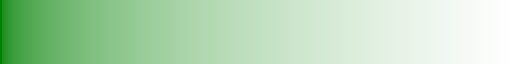

In [21]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("cust0", ['green', 'white'], gamma=0.4)
my_cmap

## Visualize Radial Neurons

In [22]:
import dtnnlib as dtnn

In [23]:
## Define piecewise MLP
torch.manual_seed(103)

h = 8
net = nn.Sequential(
            dtnn.DistanceTransform_MinExp(2, h),
            nn.Sequential(
                dtnn.ScaleShift(h),
                dtnn.OneActiv(h, mode="exp_1.6"),
            ),
            nn.Linear(h, 1),
)

In [24]:
device = torch.device("cpu")

In [25]:
xx, yy = xx.to(device), yy.to(device)
net.to(device)

Sequential(
  (0): DistanceTransform_MinExp()
  (1): Sequential(
    (0): ScaleShift()
    (1): OneActiv()
  )
  (2): Linear(in_features=8, out_features=1, bias=True)
)

In [26]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [27]:
for epoch in range(5000):

    yout = net(xx)
    loss =criterion(yout, yy)
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')

Epoch:0 | Error:0.2819773554801941
Epoch:200 | Error:0.11520526558160782
Epoch:400 | Error:0.09524613618850708
Epoch:600 | Error:0.07139284163713455
Epoch:800 | Error:0.05625537037849426
Epoch:1000 | Error:0.04733167216181755
Epoch:1200 | Error:0.04085255414247513
Epoch:1400 | Error:0.035327162593603134
Epoch:1600 | Error:0.0315551795065403
Epoch:1800 | Error:0.02892848290503025
Epoch:2000 | Error:0.0269528366625309
Epoch:2200 | Error:0.025595294311642647
Epoch:2400 | Error:0.02461838163435459
Epoch:2600 | Error:0.023888880386948586
Epoch:2800 | Error:0.023316536098718643
Epoch:3000 | Error:0.02284231036901474
Epoch:3200 | Error:0.02242394909262657
Epoch:3400 | Error:0.022046934813261032
Epoch:3600 | Error:0.02170870453119278
Epoch:3800 | Error:0.021395964547991753
Epoch:4000 | Error:0.02113129384815693
Epoch:4200 | Error:0.020841803401708603
Epoch:4400 | Error:0.020527785643935204
Epoch:4600 | Error:0.020207323133945465
Epoch:4800 | Error:0.01998499222099781


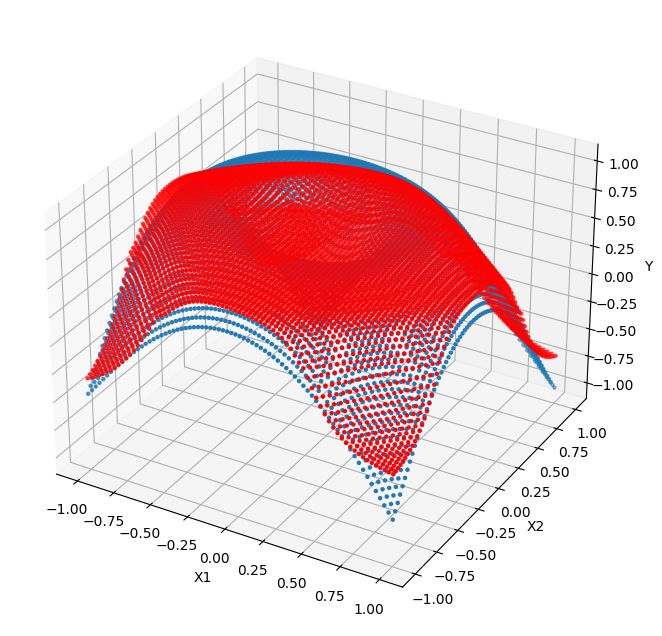

In [28]:
%matplotlib inline

yout_ = yout.data.cpu().reshape(Y.shape)

fig = plt.figure(figsize=(9,8))
ax = plt.axes(projection='3d')
ax.scatter(X1, X2, Y, marker= '.')
ax.scatter(X1, X2, yout_, color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [29]:
centers = net[0].centers.data.cpu()
centers

tensor([[-0.2912,  0.1181],
        [-0.4318,  0.2206],
        [-1.0577,  1.2323],
        [-0.4298,  0.2192],
        [ 0.8603,  1.8509],
        [-0.4308,  0.2197],
        [-1.6319, -1.1497],
        [ 1.4926, -1.8149]])

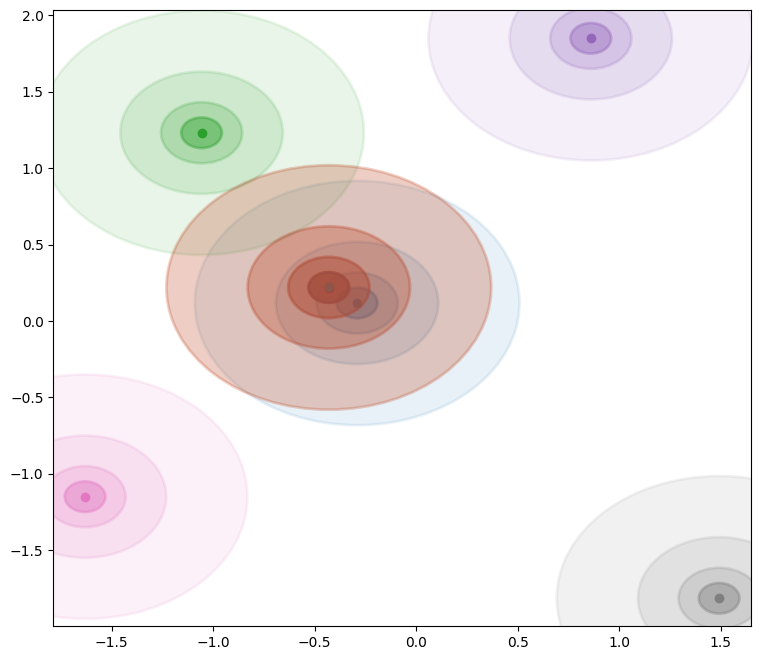

In [30]:
fig = plt.figure(figsize=(9,8))
ax = fig.gca()
for i, cent in enumerate(centers):
    color = matplotlib.cm.tab10(i)
#     print(cent)
    alpha = 0.4
    for scale in [2, 4, 8, 16]:
        ell = matplotlib.patches.Ellipse(cent, scale*0.1, scale*0.1, 180., edgecolor=color, facecolor=color, lw=2)
#             ell.set_clip_box(ax.bbox)
        ell.set_alpha(alpha/np.log2(scale))
        ax.add_artist(ell)
        pass
    plt.scatter(cent[0], cent[1], color=color)
#     pts = lines[i,0]*interp + lines[i,1]*(1-interp)
#     for j in range(len(pts)): 
#         plt.arrow(pts[j,0], pts[j,1], vecs[i][0]/10, vecs[i][1]/10, head_width=0.05, head_length=0.04, fc=color, ec=color, linestyle='solid', alpha=0.5)
    
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)

In [31]:
actf = net[0](xx).data.cpu()

In [32]:
index = np.random.randint(len(actf))
index

3624

In [33]:
# index = 3660, 603, 5012, 4993
index = 4993

In [34]:
actf[index]

tensor([1.0000, 0.9700, 0.3186, 0.9711, 0.3372, 0.9703, 0.0144, 0.0075])

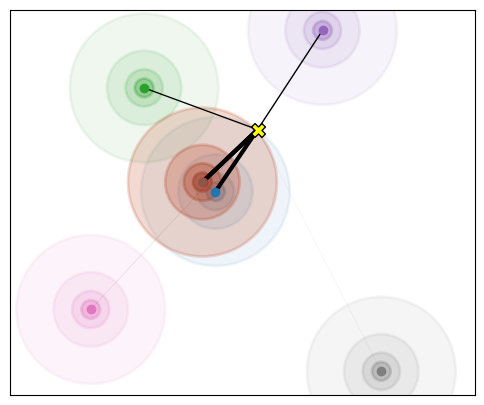

In [37]:
fig = plt.figure(figsize=(6,5))
ax = fig.gca()
alpha = 0.3

# index = np.random.randint(len(actf))
_x0, _x1 = xx[index][0].item(), xx[index][1].item()

for i, cent in enumerate(centers):
    color = matplotlib.cm.tab10(i)
    for scale in [2, 4, 8, 16]:
        ell = matplotlib.patches.Ellipse(cent, scale*0.1, scale*0.1, 180., edgecolor=color, facecolor=color, lw=2)
#             ell.set_clip_box(ax.bbox)
        ell.set_alpha(alpha/np.log2(scale))
        ax.add_artist(ell)
        pass

#     for scale, alp in zip([2, 4, 8, 16, 32], [1, 0.5, 0.25, 0.125, 0.025]):
#         ell = matplotlib.patches.Ellipse(cent, scale*0.1, scale*0.1, 180., edgecolor=color, facecolor=color, lw=1)
#         ell.set_alpha(alpha*alp)
#         ax.add_artist(ell)
#         pass
    
    plt.plot([cent[0], _x0], [cent[1], _x1], lw=actf[index][i].item()*3, color='k', zorder=10)
    plt.scatter(cent[0], cent[1], color=color, zorder=100)
    pass
plt.scatter(_x0, _x1, edgecolors='k', facecolors='yellow', s=100, lw=1, marker='X', zorder=99)

plt.axis("equal")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig("./outputs/01.3_neuron_viz/dist_minexp_neurons_2d.pdf", bbox_inches='tight')

In [36]:
index

4993